In [2]:
import pandas as pd
import numpy as np
import sklearn

print('scikit-learn: {}'.format(sklearn.__version__))
print('pandas: {}'.format(pd.__version__))
print('numpy: {}'.format(np.__version__))

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

scikit-learn: 0.22.2.post1
pandas: 1.1.4
numpy: 1.18.5


In [4]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn.cluster import KMeans
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import SilhouetteVisualizer
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [5]:
# Upload the dataset

from google.colab import files
uploaded = files.upload()

Saving jewelry_customers.csv to jewelry_customers.csv


### Load, Clean and Preprocess 

In [16]:
# Read in the data

df = pd.read_csv("jewelry_customers.csv") 

In [17]:
# Notice that not all columns are pre-processed and the dataset is small

print('Shape of dataset:', df.shape)
df.head(3)

Shape of dataset: (505, 4)


,Age,Income,SpendingScore,Savings
0,58,77769,0.791329,6559.829923
1,59,81799,0.791082,5417.661426
2,62,74751,0.702657,9258.992965


Text(0.5, 1.0, 'Age Distribution')

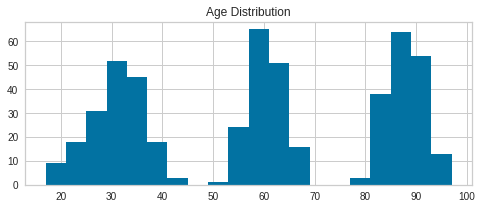

Text(0.5, 1.0, 'Income Distribution')

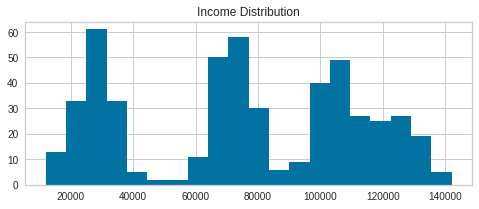

Text(0.5, 1.0, 'SpendingScore Distribution')

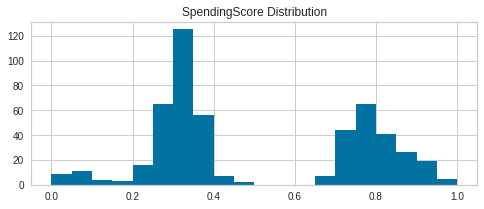

Text(0.5, 1.0, 'Savings Distribution')

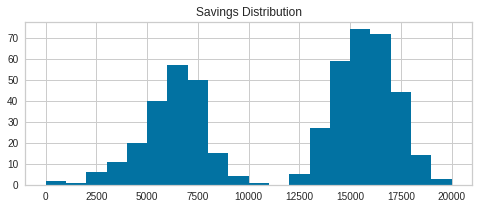

In [18]:
# Look at the distribution

list_columns = df.columns
num_bins = 20

for col in list_columns:
  fig, ax = plt.subplots()
  fig.set_size_inches(8, 3)
  n, bins, patches = ax.hist(df[col], num_bins)
  ax.set_title((col + ' Distribution'))
  plt.show()

In [19]:
# Create column names for scaling

list_scaled = []
for col in list_columns:
  list_scaled.append(col+'_Scaled')
print(list_scaled)

['Age_Scaled', 'Income_Scaled', 'SpendingScore_Scaled', 'Savings_Scaled']


In [20]:
# Scale

scale = StandardScaler()
df[(list_scaled)] = scale.fit_transform(df[(list_columns)])
print('Shape of dataset:', df.shape)
df.head(3)

Shape of dataset: (505, 8)


,Age,Income,SpendingScore,Savings,Age_Scaled,Income_Scaled,SpendingScore_Scaled,Savings_Scaled
0,58,77769,0.791329,6559.829923,-0.042287,0.062733,1.103593,-1.072467
1,59,81799,0.791082,5417.661426,-0.000821,0.174811,1.102641,-1.303473
2,62,74751,0.702657,9258.992965,0.123577,-0.021200,0.761727,-0.526556


In [21]:
# Check out the variance of the scaled features, looks very good for all 4

sel = VarianceThreshold(threshold=(.95))
sel.fit(df[(list_scaled)])
sel.get_support()

VarianceThreshold(threshold=0.95)

array([ True,  True,  True,  True])

### Cluster the Data 

   number of clusters  silhouette score
0                   2          0.521259
1                   3          0.696348
2                   4          0.758119
3                   5          0.804898
4                   6          0.633181
5                   7          0.442781
6                   8          0.298031

 Max score is 0.8049 with 5 clusters.



Text(0.5, 1.0, 'Looking for Max Silhouette Score')

Text(0.5, 0, 'number of clusters')

Text(0, 0.5, 'silhouette score')

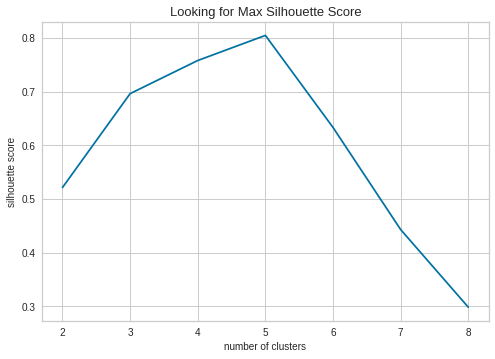

In [23]:
# Choose the best number of clusters, assuming max is best for business

range_n_clusters = [2,3,4,5,6,7,8]
nclusters = []
sil_score = []

for n_clusters in range_n_clusters:
  
    clusterer = KMeans(n_clusters=n_clusters).fit(df[list_scaled]) 
    labels = clusterer.labels_
    silhouette = silhouette_score(df[(list_scaled)],labels, metric='euclidean')  
    nclusters.append(n_clusters)
    sil_score.append(silhouette)
    
output = list(zip(nclusters,sil_score))
choice = pd.DataFrame(list(output)) 
choice.columns = ['number of clusters','silhouette score']
print(choice)

max_score = choice['silhouette score'].max()
best_clusters =  choice[choice['silhouette score'] == max_score]['number \
of clusters'].max()

print('\n','Max score is', np.round(max_score,4), 'with', best_clusters,
      'clusters.\n')

# Plot scores 

plt.plot(choice['number of clusters'], choice['silhouette score'])
plt.title ('Looking for Max Silhouette Score',fontsize=13)
plt.xlabel ('number of clusters',fontsize=10)
plt.ylabel ('silhouette score',fontsize=10)
plt.show()

SilhouetteVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f60a445d438>,
                     model=None)

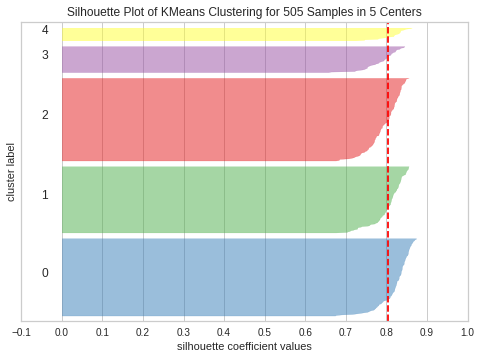

In [24]:
# Check silhouette scores by cluster using best cluster count chosen above

model = KMeans(best_clusters, random_state=42)
visualizer = SilhouetteVisualizer(model, colors='yellowbrick')
visualizer.fit(df[list_scaled])      
visualizer.poof()

   number of clusters         WCSS
0                   2  1022.390504
1                   3   384.811186
2                   4   189.701788
3                   5    66.511114
4                   6    61.131964
5                   7    56.902035
6                   8    52.869039 



Text(0.5, 1.0, 'Looking for Low WCSS')

Text(0.5, 0, 'number of clusters')

Text(0, 0.5, 'wcss')

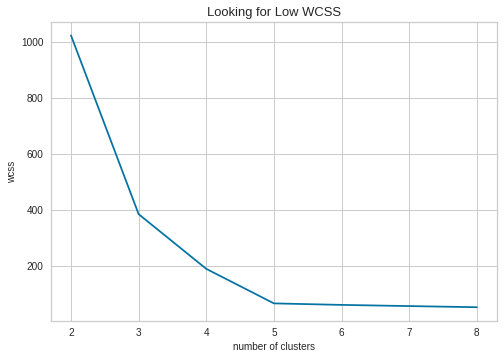

In [25]:
# Be sure the inner distance is OK too, hoping to see less of a slope in 
# decrease as cluster number goes up (elbow)

n2clusters = []
wcss = []

for n2_clusters in range_n_clusters:
    clusterer = KMeans(n_clusters = n2_clusters) 
    clusterer = clusterer.fit(df[(list_scaled)])
    wcss.append(clusterer.inertia_)
    n2clusters.append(n2_clusters)
    
output = list(zip(n2clusters,wcss))

wcss_choice = pd.DataFrame(list(output)) 
wcss_choice.columns = ['number of clusters','WCSS']

print(wcss_choice,'\n')

plt.plot(wcss_choice['number of clusters'], wcss_choice['WCSS'])
plt.title ('Looking for Low WCSS',fontsize=13)
plt.xlabel ('number of clusters',fontsize=10)
plt.ylabel ('wcss',fontsize=10)
plt.show()


### Print Summary Statistics 

In [26]:
# Create final clusters and get labels

clusterer = KMeans(n_clusters=best_clusters).fit(df[list_scaled]) 
labels = clusterer.labels_
C = clusterer.cluster_centers_
df['Cluster'] = labels

for col in list_columns:
  print(col)
  print(df[(col)].groupby(df['Cluster']).agg(['count',
                                              'mean','min','max','sum']))
  print('\n')

Age
         count       mean  min  max    sum
Cluster                                   
0          157  59.955414   51   68   9413
1          147  87.775510   79   97  12903
2          126  32.777778   22   44   4130
3           50  24.180000   17   31   1209
4           25  86.000000   77   93   2150


Income
         count           mean     min     max       sum
Cluster                                                
0          157   72448.063694   56321   90422  11374346
1          147   27866.102041   12000   46977   4096317
2          126  105265.809524   89598  119877  13263492
3           50  128029.120000  117108  142000   6401456
4           25  119944.040000  110582  128596   2998601


SpendingScore
         count      mean       min       max         sum
Cluster                                                 
0          157  0.771518  0.657314  0.910417  121.128384
1          147  0.328800  0.203140  0.473550   48.333668
2          126  0.309926  0.174120  0.411112   39.

Text(0.5, 1.0, 'Snake Plot of Clusters for Store')

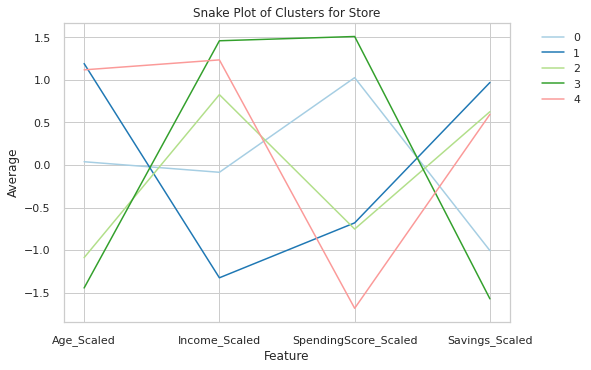

In [34]:
# Visualize snake plot with scaled values

df_vis = df[list_scaled].groupby(df['Cluster']).agg(['mean']).reset_index()
df_vis.columns = ['Cluster','Age_Scaled','Income_Scaled','SpendingScore_Scaled'
,'Savings_Scaled']
df_vis = pd.melt(df_vis.reset_index(),
                      id_vars = 'Cluster',
                      value_vars = ['Age_Scaled','Income_Scaled',
                                    'SpendingScore_Scaled','Savings_Scaled'],
                      var_name = 'Feature',
                      value_name = 'Average')
sns.set(style="whitegrid")
sns.lineplot('Feature', 'Average', hue='Cluster', data=df_vis, 
             palette='Paired').set_title('Snake Plot of Clusters for Store')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2)